# 2nd Order BRF {#sec-2nd-order-brf}

## Abstract {.unnumbered}

## Introduction
This notebook walks through the Python code used to generate and solve the circuit network equations. The example starts with a net list for the circuit shown below. 

![](2nd_order_BRF.png)


## Circuit description
The circuit below is a 2nd order band reject filter, problem 13-20 from @Budak1974. The schematic of the circuit is shown below with each node explicity annotated. The problem asks to obtain: $\frac {V_o} {V_i}$, which according to the way I have labled the nodes, is $\frac {V_2} {V_1}$.

<!--
<img src="2nd_order_BRF.png" width="700">  
-->


The net list for this circuit is:
```
* 2nd order BRF
O1 2 5 2 
V1 1 0 1
C3 3 0 2
C1 4 1 1
C2 5 4 1
R1 2 4 0.5
R2 3 1 1
R3 5 3 1
```
Reference:   
1. Aram Budak, [Passive and Active Network Analysis and Synthesis](https://www.amazon.com/Passive-Active-Network-Analysis-Synthesis/dp/0881336254), Houghton Mifflin Comp. 1974

In [1]:
import os
from sympy import *
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import SymMNA
init_printing()

## Load the net list
independent sources have their values set to the DC value.

In [2]:
example_net_list = '''
O1 2 5 2 
V1 1 0 1
C3 3 0 2
C1 4 1 1
C2 5 4 1
R1 2 4 0.5
R2 3 1 1
R3 5 3 1
'''

In [3]:
report, df, df2, A, X, Z = SymMNA.smna(example_net_list)

In [4]:
print(report)

Net list report
number of lines in netlist: 8
number of branches: 7
number of nodes: 5
number of unknown currents: 2
number of RLC (passive components): 6
number of inductors: 0
number of independent voltage sources: 1
number of independent current sources: 0
number of op amps: 1
number of E - VCVS: 0
number of G - VCCS: 0
number of F - CCCS: 0
number of H - CCVS: 0
number of K - Coupled inductors: 0



In [5]:
# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

In [6]:
X

⎡ v₁ ⎤
⎢    ⎥
⎢ v₂ ⎥
⎢    ⎥
⎢ v₃ ⎥
⎢    ⎥
⎢ v₄ ⎥
⎢    ⎥
⎢ v₅ ⎥
⎢    ⎥
⎢I_V1⎥
⎢    ⎥
⎣I_O1⎦

In [7]:
Z

⎡0 ⎤
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎢V₁⎥
⎢  ⎥
⎣0 ⎦

In [8]:
equ = Eq(A*X,Z)

In [9]:
equ

⎡                          ⎛       1 ⎞   v₃     ⎤       
⎢     -C₁⋅s⋅v₄ + I_V1 + v₁⋅⎜C₁⋅s + ──⎟ - ──     ⎥       
⎢                          ⎝       R₂⎠   R₂     ⎥       
⎢                                               ⎥       
⎢                       v₂   v₄                 ⎥       
⎢                I_O1 + ── - ──                 ⎥   ⎡0 ⎤
⎢                       R₁   R₁                 ⎥   ⎢  ⎥
⎢                                               ⎥   ⎢0 ⎥
⎢            ⎛       1    1 ⎞   v₅   v₁         ⎥   ⎢  ⎥
⎢         v₃⋅⎜C₃⋅s + ── + ──⎟ - ── - ──         ⎥   ⎢0 ⎥
⎢            ⎝       R₃   R₂⎠   R₃   R₂         ⎥   ⎢  ⎥
⎢                                               ⎥ = ⎢0 ⎥
⎢                        ⎛              1 ⎞   v₂⎥   ⎢  ⎥
⎢-C₁⋅s⋅v₁ - C₂⋅s⋅v₅ + v₄⋅⎜C₁⋅s + C₂⋅s + ──⎟ - ──⎥   ⎢0 ⎥
⎢                        ⎝              R₁⎠   R₁⎥   ⎢  ⎥
⎢                                               ⎥   ⎢V₁⎥
⎢                      ⎛       1 ⎞   v₃         ⎥   ⎢  ⎥
⎢        -C₂⋅s⋅v₄ + v₅⋅⎜C₂⋅s + 

In [10]:
# turn the free symbols into SymPy variables
var(str(equ.free_symbols).replace('{','').replace('}',''))

## Symbolic MNA code 

In [11]:
# initialize variables
num_rlc = 0 # number of passive elements
num_ind = 0 # number of inductors
num_v = 0    # number of independent voltage sources
num_i = 0    # number of independent current sources
i_unk = 0  # number of current unknowns
num_opamps = 0   # number of op amps
num_vcvs = 0     # number of controlled sources of various types
num_vccs = 0
num_cccs = 0
num_ccvs = 0
num_cpld_ind = 0 # number of coupled inductors

## Read the net list and preprocess it
The following steps are performed:   

- remove blank lines and comments  
- convert first letter of element name to upper case  
- removes extra spaces between entries  
- count number of entries on each line, make sure the count is correct, count each element type  

In [12]:
example_net_list = '''O1 2 5 2 
V1 1 0 1
C3 3 0 2
C1 4 1 1
C2 5 4 1
R1 2 4 0.5
R2 3 1 1
R3 5 3 1'''

In [13]:
content = example_net_list.splitlines()

content = [x.strip() for x in content]  #remove leading and trailing white space
# remove empty lines
while '' in content:
    content.pop(content.index(''))

# remove comment lines, these start with a asterisk *
content = [n for n in content if not n.startswith('*')]
# remove other comment lines, these start with a semicolon ;
content = [n for n in content if not n.startswith(';')]
# remove spice directives, these start with a period, .
content = [n for n in content if not n.startswith('.')]
# converts 1st letter to upper case
#content = [x.upper() for x in content] <- this converts all to upper case
content = [x.capitalize() for x in content]
# removes extra spaces between entries
content = [' '.join(x.split()) for x in content]

In [14]:
for i in content:
    print(i)

O1 2 5 2
V1 1 0 1
C3 3 0 2
C1 4 1 1
C2 5 4 1
R1 2 4 0.5
R2 3 1 1
R3 5 3 1


In [15]:
line_cnt = len(content) # number of lines in the netlist
branch_cnt = 0  # number of branches in the netlist
# check number of entries on each line, count each element type
for i in range(line_cnt):
    x = content[i][0]
    tk_cnt = len(content[i].split()) # split the line into a list of words

    if (x == 'R') or (x == 'L') or (x == 'C'):
        if tk_cnt != 4:
            print("branch {:d} not formatted correctly, {:s}".format(i,content[i]))
            print("had {:d} items and should only be 4".format(tk_cnt))
        num_rlc += 1
        branch_cnt += 1
        if x == 'L':
            num_ind += 1
    elif x == 'V':
        if tk_cnt != 4:
            print("branch {:d} not formatted correctly, {:s}".format(i,content[i]))
            print("had {:d} items and should only be 4".format(tk_cnt))
        num_v += 1
        branch_cnt += 1
    elif x == 'I':
        if tk_cnt != 4:
            print("branch {:d} not formatted correctly, {:s}".format(i,content[i]))
            print("had {:d} items and should only be 4".format(tk_cnt))
        num_i += 1
        branch_cnt += 1
    elif x == 'O':
        if tk_cnt != 4:
            print("branch {:d} not formatted correctly, {:s}".format(i,content[i]))
            print("had {:d} items and should only be 4".format(tk_cnt))
        num_opamps += 1
    elif x == 'E':
        if (tk_cnt != 6):
            print("branch {:d} not formatted correctly, {:s}".format(i,content[i]))
            print("had {:d} items and should only be 6".format(tk_cnt))
        num_vcvs += 1
        branch_cnt += 1
    elif x == 'G':
        if (tk_cnt != 6):
            print("branch {:d} not formatted correctly, {:s}".format(i,content[i]))
            print("had {:d} items and should only be 6".format(tk_cnt))
        num_vccs += 1
        branch_cnt += 1
    elif x == 'F':
        if (tk_cnt != 5):
            print("branch {:d} not formatted correctly, {:s}".format(i,content[i]))
            print("had {:d} items and should only be 5".format(tk_cnt))
        num_cccs += 1
        branch_cnt += 1
    elif x == 'H':
        if (tk_cnt != 5):
            print("branch {:d} not formatted correctly, {:s}".format(i,content[i]))
            print("had {:d} items and should only be 5".format(tk_cnt))
        num_ccvs += 1
        branch_cnt += 1
    elif x == 'K':
        if (tk_cnt != 4):
            print("branch {:d} not formatted correctly, {:s}".format(i,content[i]))
            print("had {:d} items and should only be 4".format(tk_cnt))
        num_cpld_ind += 1
    else:
        print("unknown element type in branch {:d}, {:s}".format(i,content[i]))

## Parser
The parser performs the following operations.

1. puts branch elements into data frame  
2. counts number of nodes  

data frame labels:  

- element: type of element  
- p node: positive node  
- n node: negative node, for a current source, the arrow point terminal, LTspice puts the inductor phasing dot on this terminal  
- cp node: controlling positive node of branch  
- cn node: controlling negative node of branch  
- Vout: opamp output node  
- value: value of element or voltage  
- Vname: voltage source through which the controlling current flows. Need to add a zero volt voltage source to the controlling branch.  
- Lname1: name of coupled inductor 1  
- Lname2: name of coupled inductor 2  

In [16]:
# build the pandas data frame
df = pd.DataFrame(columns=['element','p node','n node','cp node','cn node',
    'Vout','value','Vname','Lname1','Lname2'])

# this data frame is for branches with unknown currents
df2 = pd.DataFrame(columns=['element','p node','n node'])

### Functions to load branch elements into data frame and check for gaps in node numbering

In [17]:
# loads voltage or current sources into branch structure
def indep_source(line_nu):
    tk = content[line_nu].split()
    df.loc[line_nu,'element'] = tk[0]
    df.loc[line_nu,'p node'] = int(tk[1])
    df.loc[line_nu,'n node'] = int(tk[2])
    df.loc[line_nu,'value'] = float(tk[3])

# loads passive elements into branch structure
def rlc_element(line_nu):
    tk = content[line_nu].split()
    df.loc[line_nu,'element'] = tk[0]
    df.loc[line_nu,'p node'] = int(tk[1])
    df.loc[line_nu,'n node'] = int(tk[2])
    df.loc[line_nu,'value'] = float(tk[3])

# loads multi-terminal elements into branch structure
# O - Op Amps
def opamp_sub_network(line_nu):
    tk = content[line_nu].split()
    df.loc[line_nu,'element'] = tk[0]
    df.loc[line_nu,'p node'] = int(tk[1])
    df.loc[line_nu,'n node'] = int(tk[2])
    df.loc[line_nu,'Vout'] = int(tk[3])

# G - VCCS
def vccs_sub_network(line_nu):
    tk = content[line_nu].split()
    df.loc[line_nu,'element'] = tk[0]
    df.loc[line_nu,'p node'] = int(tk[1])
    df.loc[line_nu,'n node'] = int(tk[2])
    df.loc[line_nu,'cp node'] = int(tk[3])
    df.loc[line_nu,'cn node'] = int(tk[4])
    df.loc[line_nu,'value'] = float(tk[5])

# E - VCVS
# in sympy E is the number 2.718, replacing E with Ea otherwise, sympify() errors out
def vcvs_sub_network(line_nu):
    tk = content[line_nu].split()
    df.loc[line_nu,'element'] = tk[0].replace('E', 'Ea')
    df.loc[line_nu,'p node'] = int(tk[1])
    df.loc[line_nu,'n node'] = int(tk[2])
    df.loc[line_nu,'cp node'] = int(tk[3])
    df.loc[line_nu,'cn node'] = int(tk[4])
    df.loc[line_nu,'value'] = float(tk[5])

# F - CCCS
def cccs_sub_network(line_nu):
    tk = content[line_nu].split()
    df.loc[line_nu,'element'] = tk[0]
    df.loc[line_nu,'p node'] = int(tk[1])
    df.loc[line_nu,'n node'] = int(tk[2])
    df.loc[line_nu,'Vname'] = tk[3].capitalize()
    df.loc[line_nu,'value'] = float(tk[4])

# H - CCVS
def ccvs_sub_network(line_nu):
    tk = content[line_nu].split()
    df.loc[line_nu,'element'] = tk[0]
    df.loc[line_nu,'p node'] = int(tk[1])
    df.loc[line_nu,'n node'] = int(tk[2])
    df.loc[line_nu,'Vname'] = tk[3].capitalize()
    df.loc[line_nu,'value'] = float(tk[4])

# K - Coupled inductors
def cpld_ind_sub_network(line_nu):
    tk = content[line_nu].split()
    df.loc[line_nu,'element'] = tk[0]
    df.loc[line_nu,'Lname1'] = tk[1].capitalize()
    df.loc[line_nu,'Lname2'] = tk[2].capitalize()
    df.loc[line_nu,'value'] = float(tk[3])

# function to scan df and get largest node number
def count_nodes():
    # need to check that nodes are consecutive
    # fill array with node numbers
    p = np.zeros(line_cnt+1)
    for i in range(line_cnt):
        # need to skip coupled inductor 'K' statements
        if df.loc[i,'element'][0] != 'K': #get 1st letter of element name
            p[df['p node'][i]] = df['p node'][i]
            p[df['n node'][i]] = df['n node'][i]

    # find the largest node number
    if df['n node'].max() > df['p node'].max():
        largest = df['n node'].max()
    else:
        largest =  df['p node'].max()

    largest = int(largest)
    # check for unfilled elements, skip node 0
    for i in range(1,largest):
        if p[i] == 0:
            print('nodes not in continuous order, node {:.0f} is missing'.format(p[i-1]+1))

    return largest

### Load circuit netlist into the data frames

In [18]:
# load branch info into data frame
for i in range(line_cnt):
    x = content[i][0]

    if (x == 'R') or (x == 'L') or (x == 'C'):
        rlc_element(i)
    elif (x == 'V') or (x == 'I'):
        indep_source(i)
    elif x == 'O':
        opamp_sub_network(i)
    elif x == 'E':
        vcvs_sub_network(i)
    elif x == 'G':
        vccs_sub_network(i)
    elif x == 'F':
        cccs_sub_network(i)
    elif x == 'H':
        ccvs_sub_network(i)
    elif x == 'K':
        cpld_ind_sub_network(i)
    else:
        print("unknown element type in branch {:d}, {:s}".format(i,content[i]))

29 Nov 2023:  When the D matrix is built, independent voltage sources are processed in the data frame order when building the D matrix. If the voltage source followed element L, H, F, K types in the netlist, a row was inserted that put the voltage source in a different row in relation to its position in the Ev matrix. This would cause the node attached to the terminal of the voltage source to be zero volts.  
Solution - The following block of code was added to move voltage source types to the beginning of the net list dataframe before any calculations are performed. 

In [19]:
# Check for position of voltages sources in the dataframe.
source_index = [] # keep track of voltage source row number
other_index = [] # make a list of all other types
for i in range(len(df)):
    # process all the elements creating unknown currents
    x = df.loc[i,'element'][0]   #get 1st letter of element name
    if (x == 'V'):
        source_index.append(i)
    else:
        other_index.append(i)

df = df.reindex(source_index+other_index,copy=True) # re-order the data frame
df.reset_index(drop=True, inplace=True) # renumber the index

In [20]:
# count number of nodes
num_nodes = count_nodes()

# Build df2: consists of branches with current unknowns, used for C & D matrices
# walk through data frame and find these parameters
count = 0
for i in range(len(df)):
    # process all the elements creating unknown currents
    x = df.loc[i,'element'][0]   #get 1st letter of element name
    if (x == 'L') or (x == 'V') or (x == 'O') or (x == 'E') or (x == 'H') or (x == 'F'):
        df2.loc[count,'element'] = df.loc[i,'element']
        df2.loc[count,'p node'] = df.loc[i,'p node']
        df2.loc[count,'n node'] = df.loc[i,'n node']
        count += 1

## Print net list report

In [21]:
# print a report
print('Net list report')
print('number of lines in netlist: {:d}'.format(line_cnt))
print('number of branches: {:d}'.format(branch_cnt))
print('number of nodes: {:d}'.format(num_nodes))
# count the number of element types that affect the size of the B, C, D, E and J arrays
# these are current unknows
i_unk = num_v+num_opamps+num_vcvs+num_ccvs+num_cccs+num_ind
print('number of unknown currents: {:d}'.format(i_unk))
print('number of RLC (passive components): {:d}'.format(num_rlc))
print('number of inductors: {:d}'.format(num_ind))
print('number of independent voltage sources: {:d}'.format(num_v))
print('number of independent current sources: {:d}'.format(num_i))
print('number of op amps: {:d}'.format(num_opamps))
print('number of E - VCVS: {:d}'.format(num_vcvs))
print('number of G - VCCS: {:d}'.format(num_vccs))
print('number of F - CCCS: {:d}'.format(num_cccs))
print('number of H - CCVS: {:d}'.format(num_ccvs))
print('number of K - Coupled inductors: {:d}'.format(num_cpld_ind))

Net list report
number of lines in netlist: 8
number of branches: 7
number of nodes: 5
number of unknown currents: 2
number of RLC (passive components): 6
number of inductors: 0
number of independent voltage sources: 1
number of independent current sources: 0
number of op amps: 1
number of E - VCVS: 0
number of G - VCCS: 0
number of F - CCCS: 0
number of H - CCVS: 0
number of K - Coupled inductors: 0


In [22]:
df

,element,p node,n node,cp node,cn node,Vout,value,Vname,Lname1,Lname2
0,V1,1,0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,O1,2,5,NaN,NaN,2,NaN,NaN,NaN,NaN
2,C3,3,0,NaN,NaN,NaN,2.0,NaN,NaN,NaN
3,C1,4,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4,C2,5,4,NaN,NaN,NaN,1.0,NaN,NaN,NaN
5,R1,2,4,NaN,NaN,NaN,0.5,NaN,NaN,NaN
6,R2,3,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN
7,R3,5,3,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [23]:
df2

,element,p node,n node
0,V1,1,0
1,O1,2,5


In [24]:
# store the data frame as a pickle file
# df.to_pickle(fn+'.pkl')  # <- uncomment if needed

In [25]:
# initialize some symbolic matrix with zeros
# A is formed by [[G, C] [B, D]]
# Z = [I,E]
# X = [V, J]
V = zeros(num_nodes,1)
I = zeros(num_nodes,1)
G = zeros(num_nodes,num_nodes)  # also called Yr, the reduced nodal matrix
s = Symbol('s')  # the Laplace variable

# count the number of element types that affect the size of the B, C, D, E and J arrays
# these are element types that have unknown currents
i_unk = num_v+num_opamps+num_vcvs+num_ccvs+num_ind+num_cccs
# if i_unk == 0, just generate empty arrays
B = zeros(num_nodes,i_unk)
C = zeros(i_unk,num_nodes)
D = zeros(i_unk,i_unk)
Ev = zeros(i_unk,1)
J = zeros(i_unk,1)

#### some debugging notes:
Is it possible to have i_unk == 0 ?, what about a network with only current sources?  This would make B = 0 for example. Did one test, need to run others   
Is there a valid op amp case where B is n by 1?

## G matrix
The G matrix is n by n, where n is the number of nodes. The matrix is formed by the interconnections between the resistors, capacitors and VCCS type elements.  In the original paper G is called Yr, where Yr is a reduced form of the nodal matrix excluding the contributions due to voltage sources, current controlling elements, etc.  In python row and columns are: G[row, column]


In [26]:
# G matrix
for i in range(len(df)):  # process each row in the data frame
    n1 = df.loc[i,'p node']
    n2 = df.loc[i,'n node']
    cn1 = df.loc[i,'cp node']
    cn2 = df.loc[i,'cn node']
    # process all the passive elements, save conductance to temp value
    x = df.loc[i,'element'][0]   #get 1st letter of element name
    if x == 'R':
        g = 1/sympify(df.loc[i,'element'])
    if x == 'C':
        g = s*sympify(df.loc[i,'element'])
    if x == 'G':   #vccs type element
        g = sympify(df.loc[i,'element'].lower())  # use a symbol for gain value

    if (x == 'R') or (x == 'C'):
        # If neither side of the element is connected to ground
        # then subtract it from the appropriate location in the matrix.
        if (n1 != 0) and (n2 != 0):
            G[n1-1,n2-1] += -g
            G[n2-1,n1-1] += -g

        # If node 1 is connected to ground, add element to diagonal of matrix
        if n1 != 0:
            G[n1-1,n1-1] += g

        # same for for node 2
        if n2 != 0:
            G[n2-1,n2-1] += g

    if x == 'G':    #vccs type element
        # check to see if any terminal is grounded
        # then stamp the matrix
        if n1 != 0 and cn1 != 0:
            G[n1-1,cn1-1] += g

        if n2 != 0 and cn2 != 0:
            G[n2-1,cn2-1] += g

        if n1 != 0 and cn2 != 0:
            G[n1-1,cn2-1] -= g

        if n2 != 0 and cn1 != 0:
            G[n2-1,cn1-1] -= g

G  # display the G matrix

⎡       1             -1                                    ⎤
⎢C₁⋅s + ──   0        ───             -C₁⋅s            0    ⎥
⎢       R₂             R₂                                   ⎥
⎢                                                           ⎥
⎢           1                          -1                   ⎥
⎢    0      ──         0               ───             0    ⎥
⎢           R₁                          R₁                  ⎥
⎢                                                           ⎥
⎢   -1                  1    1                        -1    ⎥
⎢   ───      0   C₃⋅s + ── + ──         0             ───   ⎥
⎢    R₂                 R₃   R₂                        R₃   ⎥
⎢                                                           ⎥
⎢           -1                                 1            ⎥
⎢  -C₁⋅s    ───        0         C₁⋅s + C₂⋅s + ──    -C₂⋅s  ⎥
⎢            R₁                                R₁           ⎥
⎢                                                           ⎥
⎢       

## B Matrix
The B matrix is an n by m matrix with only 0, 1 and -1 elements, where n = number of nodes and m is the number of current unknowns, i_unk. There is one column for each unknown current. The code loop through all the branches and process elements that have stamps for the B matrix:   

- Voltage sources (V)  
- Opamps (O)  
- CCVS (H)  
- CCCS (F)  
- VCVS (E)  
- Inductors (L)    

The order of the columns is as they appear in the netlist.  CCCS (F) does not get its own column because the controlling current is through a zero volt voltage source, called Vname and is already in the net list.

In [27]:
# generate the B Matrix
sn = 0   # count source number as code walks through the data frame
for i in range(len(df)):
    n1 = df.loc[i,'p node']
    n2 = df.loc[i,'n node']
    n_vout = df.loc[i,'Vout'] # node connected to op amp output

    # process elements with input to B matrix
    x = df.loc[i,'element'][0]   #get 1st letter of element name
    if x == 'V':
        if i_unk > 1:  #is B greater than 1 by n?, V
            if n1 != 0:
                B[n1-1,sn] = 1
            if n2 != 0:
                B[n2-1,sn] = -1
        else:
            if n1 != 0:
                B[n1-1] = 1
            if n2 != 0:
                B[n2-1] = -1
        sn += 1   #increment source count
    if x == 'O':  # op amp type, output connection of the opamp goes in the B matrix
        B[n_vout-1,sn] = 1
        sn += 1   # increment source count
    if (x == 'H') or (x == 'F'):  # H: ccvs, F: cccs,
        if i_unk > 1:  #is B greater than 1 by n?, H, F
            # check to see if any terminal is grounded
            # then stamp the matrix
            if n1 != 0:
                B[n1-1,sn] = 1
            if n2 != 0:
                B[n2-1,sn] = -1
        else:
            if n1 != 0:
                B[n1-1] = 1
            if n2 != 0:
                B[n2-1] = -1
        sn += 1   #increment source count
    if x == 'E':   # vcvs type, only ik column is altered at n1 and n2
        if i_unk > 1:  #is B greater than 1 by n?, E
            if n1 != 0:
                B[n1-1,sn] = 1
            if n2 != 0:
                B[n2-1,sn] = -1
        else:
            if n1 != 0:
                B[n1-1] = 1
            if n2 != 0:
                B[n2-1] = -1
        sn += 1   #increment source count
    if x == 'L':
        if i_unk > 1:  #is B greater than 1 by n?, L
            if n1 != 0:
                B[n1-1,sn] = 1
            if n2 != 0:
                B[n2-1,sn] = -1
        else:
            if n1 != 0:
                B[n1-1] = 1
            if n2 != 0:
                B[n2-1] = -1
        sn += 1   #increment source count

# check source count
if sn != i_unk:
    print('source number, sn={:d} not equal to i_unk={:d} in matrix B'.format(sn,i_unk))

B   # display the B matrix

⎡1  0⎤
⎢    ⎥
⎢0  1⎥
⎢    ⎥
⎢0  0⎥
⎢    ⎥
⎢0  0⎥
⎢    ⎥
⎣0  0⎦

## C matrix
The C matrix is an m by n matrix with only 0, 1 and -1 elements (except for controlled sources).  The code is similar to the B matrix code, except the indices are swapped.   The code loops through all the branches and process elements that have stamps for the C matrix:  

- Voltage sources (V)  
- Opamps (O)  
- CCVS (H)  
- CCCS (F)  
- VCVS (E)  
- Inductors (L)  

### Op Amp elements
The op amp element is assumed to be an ideal op amp and use of this component is valid only when used in circuits with a DC path (a short or a resistor) from the output terminal to the negative input terminal of the op amp. No error checking is provided and if the condition is violated, the results likely will be erroneous.   

References use in the debugging of the opamp stamp:   

1. Design of Analog Circuits Through Symbolic Analysis, edited by Mourad Fakhfakh, Esteban Tlelo-Cuautle, Francisco V. Fernández   
2. Computer Aided Design and Design Automation, edited by Wai-Kai Chen  


In [28]:
# find the the column position in the C and D matrix for controlled sources
# needs to return the node numbers and branch number of controlling branch
def find_vname(name):
    # need to walk through data frame and find these parameters
    for i in range(len(df2)):
        # process all the elements creating unknown currents
        if name == df2.loc[i,'element']:
            n1 = df2.loc[i,'p node']
            n2 = df2.loc[i,'n node']
            return n1, n2, i  # n1, n2 & col_num are from the branch of the controlling element

    print('failed to find matching branch element in find_vname')

In [29]:
# generate the C Matrix
sn = 0   # count source number as code walks through the data frame
for i in range(len(df)):
    n1 = df.loc[i,'p node']
    n2 = df.loc[i,'n node']
    cn1 = df.loc[i,'cp node'] # nodes for controlled sources
    cn2 = df.loc[i,'cn node']
    n_vout = df.loc[i,'Vout'] # node connected to op amp output

    # process elements with input to B matrix
    x = df.loc[i,'element'][0]   #get 1st letter of element name
    if x == 'V':
        if i_unk > 1:  #is B greater than 1 by n?, V
            if n1 != 0:
                C[sn,n1-1] = 1
            if n2 != 0:
                C[sn,n2-1] = -1
        else:
            if n1 != 0:
                C[n1-1] = 1
            if n2 != 0:
                C[n2-1] = -1
        sn += 1   #increment source count

    if x == 'O':  # op amp type, input connections of the opamp go into the C matrix
        # C[sn,n_vout-1] = 1
        if i_unk > 1:  #is B greater than 1 by n?, O
            # check to see if any terminal is grounded
            # then stamp the matrix
            if n1 != 0:
                C[sn,n1-1] = 1
            if n2 != 0:
                C[sn,n2-1] = -1
        else:
            if n1 != 0:
                C[n1-1] = 1
            if n2 != 0:
                C[n2-1] = -1
        sn += 1   # increment source count

    if x == 'F':  # need to count F (cccs) types
        sn += 1   #increment source count
    if x == 'H':  # H: ccvs
        if i_unk > 1:  #is B greater than 1 by n?, H
            # check to see if any terminal is grounded
            # then stamp the matrix
            if n1 != 0:
                C[sn,n1-1] = 1
            if n2 != 0:
                C[sn,n2-1] = -1
        else:
            if n1 != 0:
                C[n1-1] = 1
            if n2 != 0:
                C[n2-1] = -1
        sn += 1   #increment source count
    if x == 'E':   # vcvs type, ik column is altered at n1 and n2, cn1 & cn2 get value
        if i_unk > 1:  #is B greater than 1 by n?, E
            if n1 != 0:
                C[sn,n1-1] = 1
            if n2 != 0:
                C[sn,n2-1] = -1
            # add entry for cp and cn of the controlling voltage
            if cn1 != 0:
                C[sn,cn1-1] = -sympify(df.loc[i,'element'].lower())
            if cn2 != 0:
                C[sn,cn2-1] = sympify(df.loc[i,'element'].lower())
        else:
            if n1 != 0:
                C[n1-1] = 1
            if n2 != 0:
                C[n2-1] = -1
            vn1, vn2, df2_index = find_vname(df.loc[i,'Vname'])
            if vn1 != 0:
                C[vn1-1] = -sympify(df.loc[i,'element'].lower())
            if vn2 != 0:
                C[vn2-1] = sympify(df.loc[i,'element'].lower())
        sn += 1   #increment source count

    if x == 'L':
        if i_unk > 1:  #is B greater than 1 by n?, L
            if n1 != 0:
                C[sn,n1-1] = 1
            if n2 != 0:
                C[sn,n2-1] = -1
        else:
            if n1 != 0:
                C[n1-1] = 1
            if n2 != 0:
                C[n2-1] = -1
        sn += 1   #increment source count

# check source count
if sn != i_unk:
    print('source number, sn={:d} not equal to i_unk={:d} in matrix C'.format(sn,i_unk))

C   # display the C matrix

⎡1  0  0  0  0 ⎤
⎢              ⎥
⎣0  1  0  0  -1⎦

## D matrix
The D matrix is an m by m matrix, where m is the number of unknown currents.  
> m = i_unk = num_v+num_opamps+num_vcvs+num_ccvs+num_ind+num_cccs

Stamps that affect the D matrix are: inductor, ccvs and cccs  
inductors: minus sign added to keep current flow convention consistent  

Coupled inductors notes:  
Can the K statement be anywhere in the net list, even before Lx and Ly?   
12/6/2017 doing some debugging on with coupled inductors  
LTspice seems to put the phasing dot on the neg node when it generates the netlist   
This code uses M for mutual inductance, LTspice uses k for the coupling coefficient.  

In [30]:
# generate the D Matrix
sn = 0   # count source number as code walks through the data frame
for i in range(len(df)):
    n1 = df.loc[i,'p node']
    n2 = df.loc[i,'n node']
    #cn1 = df.loc[i,'cp node'] # nodes for controlled sources
    #cn2 = df.loc[i,'cn node']
    #n_vout = df.loc[i,'Vout'] # node connected to op amp output

    # process elements with input to D matrix
    x = df.loc[i,'element'][0]   #get 1st letter of element name
    if (x == 'V') or (x == 'O') or (x == 'E'):  # need to count V, E & O types
        sn += 1   #increment source count

    if x == 'L':
        if i_unk > 1:  #is D greater than 1 by 1?
            D[sn,sn] += -s*sympify(df.loc[i,'element'])
        else:
            D[sn] += -s*sympify(df.loc[i,'element'])
        sn += 1   #increment source count

    if x == 'H':  # H: ccvs
        # if there is a H type, D is m by m
        # need to find the vn for Vname
        # then stamp the matrix
        vn1, vn2, df2_index = find_vname(df.loc[i,'Vname'])
        D[sn,df2_index] += -sympify(df.loc[i,'element'].lower())
        sn += 1   #increment source count

    if x == 'F':  # F: cccs
        # if there is a F type, D is m by m
        # need to find the vn for Vname
        # then stamp the matrix
        vn1, vn2, df2_index = find_vname(df.loc[i,'Vname'])
        D[sn,df2_index] += -sympify(df.loc[i,'element'].lower())
        D[sn,sn] = 1
        sn += 1   #increment source count

    if x == 'K':  # K: coupled inductors, KXX LYY LZZ value
        # if there is a K type, D is m by m
        vn1, vn2, ind1_index = find_vname(df.loc[i,'Lname1'])  # get i_unk position for Lx
        vn1, vn2, ind2_index = find_vname(df.loc[i,'Lname2'])  # get i_unk position for Ly
        # enter sM on diagonals = value*sqrt(LXX*LZZ)

        D[ind1_index,ind2_index] += -s*sympify('M{:s}'.format(df.loc[i,'element'].lower()[1:]))  # s*Mxx
        D[ind2_index,ind1_index] += -s*sympify('M{:s}'.format(df.loc[i,'element'].lower()[1:]))  # -s*Mxx

# display the The D matrix
D

⎡0  0⎤
⎢    ⎥
⎣0  0⎦

## V matrix
The V matrix is an n by 1 matrix formed of the node voltages, where n is the number of nodes. Each element in V corresponds to the voltage at the node.  

Maybe make small v's v_1 so as not to confuse v1 with V1.

In [31]:
# generate the V matrix
for i in range(num_nodes):
    V[i] = sympify('v{:d}'.format(i+1))

V  # display the V matrix

⎡v₁⎤
⎢  ⎥
⎢v₂⎥
⎢  ⎥
⎢v₃⎥
⎢  ⎥
⎢v₄⎥
⎢  ⎥
⎣v₅⎦

## J matrix
The J matrix is an m by 1 matrix, where m is the number of unknown currents.
>i_unk = num_v+num_opamps+num_vcvs+num_ccvs+num_ind+num_cccs

In [32]:
# The J matrix is an mx1 matrix, with one entry for each i_unk from a source
#sn = 0   # count i_unk source number
#oan = 0   #count op amp number
for i in range(len(df2)):
    # process all the unknown currents
    J[i] = sympify('I_{:s}'.format(df2.loc[i,'element']))

J  # diplay the J matrix

⎡I_V1⎤
⎢    ⎥
⎣I_O1⎦

## I matrix
The I matrix is an n by 1 matrix, where n is the number of nodes. The value of each element of I is determined by the sum of current sources into the corresponding node. If there are no current sources connected to the node, the value is zero.

In [33]:
# generate the I matrix, current sources have n2 = arrow end of the element
for i in range(len(df)):
    n1 = df.loc[i,'p node']
    n2 = df.loc[i,'n node']
    # process all the passive elements, save conductance to temp value
    x = df.loc[i,'element'][0]   #get 1st letter of element name
    if x == 'I':
        g = sympify(df.loc[i,'element'])
        # sum the current into each node
        if n1 != 0:
            I[n1-1] -= g
        if n2 != 0:
            I[n2-1] += g

I  # display the I matrix

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

## Ev matrix
The Ev matrix is mx1 and holds the values of the independent voltage sources.

In [34]:
# generate the E matrix
sn = 0   # count source number
for i in range(len(df)):
    # process all the passive elements
    x = df.loc[i,'element'][0]   #get 1st letter of element name
    if x == 'V':
        Ev[sn] = sympify(df.loc[i,'element'])
        sn += 1

Ev   # display the E matrix

⎡V₁⎤
⎢  ⎥
⎣0 ⎦

## Z matrix
The Z matrix holds the independent voltage and current sources and is the combination of 2 smaller matrices I and Ev. The Z matrix is (m+n) by 1, n is the number of nodes, and m is the number of independent voltage sources. The I matrix is n by 1 and contains the sum of the currents through the passive elements into the corresponding node (either zero, or the sum of independent current sources). The Ev matrix is m by 1 and holds the values of the independent voltage sources.

In [35]:
Z = I[:] + Ev[:]  # the + operator in python concatenates the lists
Z  # display the Z matrix

## X matrix
The X matrix is an (n+m) by 1 vector that holds the unknown quantities (node voltages and the currents through the independent voltage sources). The top n elements are the n node voltages. The bottom m elements represent the currents through the m independent voltage sources in the circuit. The V matrix is n by 1 and holds the unknown voltages. The J matrix is m by 1 and holds the unknown currents through the voltage sources

In [36]:
X = V[:] + J[:]  # the + operator in python concatenates the lists
X  # display the X matrix

## A matrix
The A matrix is (m+n) by (m+n) and will be developed as the combination of 4 smaller matrices, G, B, C, and D.

In [37]:
n = num_nodes
m = i_unk
A = zeros(m+n,m+n)
for i in range(n):
    for j in range(n):
        A[i,j] = G[i,j]

if i_unk > 1:
    for i in range(n):
        for j in range(m):
            A[i,n+j] = B[i,j]
            A[n+j,i] = C[j,i]

    for i in range(m):
        for j in range(m):
            A[n+i,n+j] = D[i,j]

if i_unk == 1:
    for i in range(n):
        A[i,n] = B[i]
        A[n,i] = C[i]
    A[n,n] = D[0] # added 1/7/2024 while debugging source free circuit with one inductor

A  # display the A matrix

⎡       1             -1                                          ⎤
⎢C₁⋅s + ──   0        ───             -C₁⋅s            0      1  0⎥
⎢       R₂             R₂                                         ⎥
⎢                                                                 ⎥
⎢           1                          -1                         ⎥
⎢    0      ──         0               ───             0      0  1⎥
⎢           R₁                          R₁                        ⎥
⎢                                                                 ⎥
⎢   -1                  1    1                        -1          ⎥
⎢   ───      0   C₃⋅s + ── + ──         0             ───     0  0⎥
⎢    R₂                 R₃   R₂                        R₃         ⎥
⎢                                                                 ⎥
⎢           -1                                 1                  ⎥
⎢  -C₁⋅s    ───        0         C₁⋅s + C₂⋅s + ──    -C₂⋅s    0  0⎥
⎢            R₁                                R

## generate the circuit equations

In [38]:
equ = Eq(A*Matrix(X),Matrix(Z))
equ

⎡                          ⎛       1 ⎞   v₃     ⎤       
⎢     -C₁⋅s⋅v₄ + I_V1 + v₁⋅⎜C₁⋅s + ──⎟ - ──     ⎥       
⎢                          ⎝       R₂⎠   R₂     ⎥       
⎢                                               ⎥       
⎢                       v₂   v₄                 ⎥       
⎢                I_O1 + ── - ──                 ⎥   ⎡0 ⎤
⎢                       R₁   R₁                 ⎥   ⎢  ⎥
⎢                                               ⎥   ⎢0 ⎥
⎢            ⎛       1    1 ⎞   v₅   v₁         ⎥   ⎢  ⎥
⎢         v₃⋅⎜C₃⋅s + ── + ──⎟ - ── - ──         ⎥   ⎢0 ⎥
⎢            ⎝       R₃   R₂⎠   R₃   R₂         ⎥   ⎢  ⎥
⎢                                               ⎥ = ⎢0 ⎥
⎢                        ⎛              1 ⎞   v₂⎥   ⎢  ⎥
⎢-C₁⋅s⋅v₁ - C₂⋅s⋅v₅ + v₄⋅⎜C₁⋅s + C₂⋅s + ──⎟ - ──⎥   ⎢0 ⎥
⎢                        ⎝              R₁⎠   R₁⎥   ⎢  ⎥
⎢                                               ⎥   ⎢V₁⎥
⎢                      ⎛       1 ⎞   v₃         ⎥   ⎢  ⎥
⎢        -C₂⋅s⋅v₄ + v₅⋅⎜C₂⋅s + 

## Symbolic solution

In [39]:
v1, v2, v3, v4, v5, I_V1, I_O = symbols('v1 v2 v3 v4 v5 I_V1 I_O')

In [40]:
symbolic_solution = solve(equ,X)

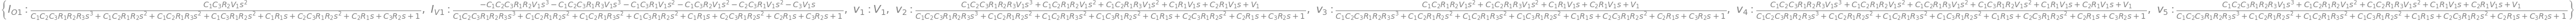

In [41]:
symbolic_solution

The symbolic solution for $\frac {V_o}{V_i}$:

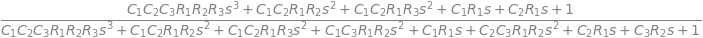

In [42]:
(symbolic_solution[v2]/symbolic_solution[v1]).factor()

Built a python dictionary of element values

In [43]:
element_value_keys = []
element_value_values = []

for i in range(len(df)):
    if df.iloc[i]['element'][0] == 'F' or df.iloc[i]['element'][0] == 'E' or df.iloc[i]['element'][0] == 'G' or df.iloc[i]['element'][0] == 'H':
        element_value_keys.append(var(df.iloc[i]['element'].lower()))
        element_value_values.append(df.iloc[i]['value'])
        #print('{:s}:{:f},'.format(df.iloc[i]['element'].lower(),df.iloc[i]['value']))
    else:
        element_value_keys.append(var(df.iloc[i]['element']))
        element_value_values.append(df.iloc[i]['value'])
        #print('{:s}:{:.4e},'.format(df.iloc[i]['element'],df.iloc[i]['value']))

element_values = dict(zip(element_value_keys, element_value_values))

## Numeric solution
Substitue the element values into the equations and solve for unknown node voltages and currents. Need to set the current source, I1, to zero.

In [44]:
equ1a = equ.subs(element_values)
equ1a

⎡  I_V1 - s⋅v₄ + v₁⋅(1.0⋅s + 1.0) - v₃   ⎤   ⎡ 0 ⎤
⎢                                        ⎥   ⎢   ⎥
⎢         I_O1 + 2.0⋅v₂ - 2.0⋅v₄         ⎥   ⎢ 0 ⎥
⎢                                        ⎥   ⎢   ⎥
⎢      -v₁ + v₃⋅(2.0⋅s + 2.0) - v₅       ⎥   ⎢ 0 ⎥
⎢                                        ⎥   ⎢   ⎥
⎢-s⋅v₁ - s⋅v₅ - 2.0⋅v₂ + v₄⋅(2.0⋅s + 2.0)⎥ = ⎢ 0 ⎥
⎢                                        ⎥   ⎢   ⎥
⎢     -s⋅v₄ - v₃ + v₅⋅(1.0⋅s + 1.0)      ⎥   ⎢ 0 ⎥
⎢                                        ⎥   ⎢   ⎥
⎢                   v₁                   ⎥   ⎢1.0⎥
⎢                                        ⎥   ⎢   ⎥
⎣                v₂ - v₅                 ⎦   ⎣ 0 ⎦

Solve for voltages and currents in terms of Laplace variable s.

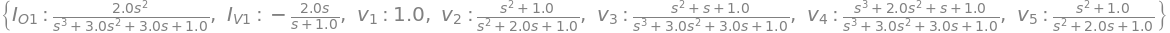

In [45]:
u1 = solve(equ1a,X)
u1

## AC analysis
Solve the equations at a frequency of 0.159154 mHz or $\omega$ equal to 1 radians per second, s = 1.

In [46]:
equ1a_1rad_per_s = equ1a.subs({s:1j})
equ1a_1rad_per_s  # display the equations

⎡  I_V1 + v₁⋅(1.0 + 1.0⋅ⅈ) - v₃ - ⅈ⋅v₄   ⎤   ⎡ 0 ⎤
⎢                                        ⎥   ⎢   ⎥
⎢         I_O1 + 2.0⋅v₂ - 2.0⋅v₄         ⎥   ⎢ 0 ⎥
⎢                                        ⎥   ⎢   ⎥
⎢      -v₁ + v₃⋅(2.0 + 2.0⋅ⅈ) - v₅       ⎥   ⎢ 0 ⎥
⎢                                        ⎥   ⎢   ⎥
⎢-ⅈ⋅v₁ - 2.0⋅v₂ + v₄⋅(2.0 + 2.0⋅ⅈ) - ⅈ⋅v₅⎥ = ⎢ 0 ⎥
⎢                                        ⎥   ⎢   ⎥
⎢     -v₃ - ⅈ⋅v₄ + v₅⋅(1.0 + 1.0⋅ⅈ)      ⎥   ⎢ 0 ⎥
⎢                                        ⎥   ⎢   ⎥
⎢                   v₁                   ⎥   ⎢1.0⎥
⎢                                        ⎥   ⎢   ⎥
⎣                v₂ - v₅                 ⎦   ⎣ 0 ⎦

In [47]:
ans1 = solve(equ1a_1rad_per_s,X)
ans1

In [48]:
for name, value in ans1.items():
    print('{:5s}: mag: {:10.6f} phase: {:11.5f} deg'.format(str(name),float(abs(value)),float(arg(value)*180/np.pi)))

v1   : mag:   1.000000 phase:     0.00000 deg
v2   : mag:   0.000000 phase:         nan deg
v3   : mag:   0.353553 phase:   -45.00000 deg
v4   : mag:   0.353553 phase:    45.00000 deg
v5   : mag:   0.000000 phase:         nan deg
I_V1 : mag:   1.414214 phase:  -135.00000 deg
I_O1 : mag:   0.707107 phase:    45.00000 deg


## AC Sweep
Looking at node 2 voltage.

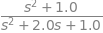

In [49]:
H = u1[v2]
H

In [50]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system = (a, b) # system for circuit

In [51]:
x = np.logspace(-1, 0, 500, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(system, w=x) # returns: rad/s, mag in dB, phase in deg

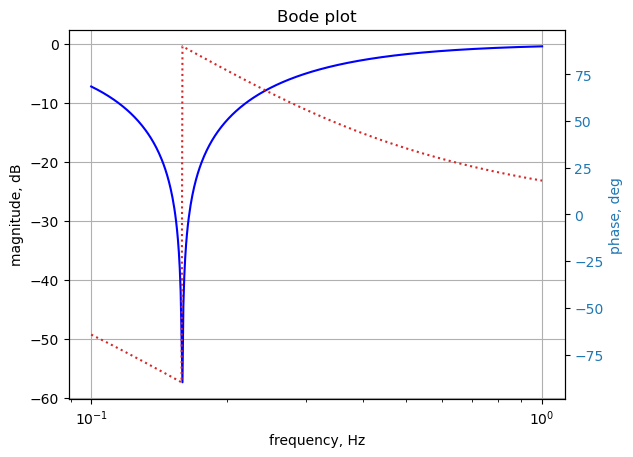

In [52]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

#plt.semilogx(frequency, np.angle(voltage)*180/np.pi,':',color=color)  # Bode phase plot
plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

In [53]:
print('null: {:.2f} dB at {:.3f} Hz'.format(mag.min(),w[np.argmin(mag)]/(2*np.pi)))

null: -57.42 dB at 0.159 Hz
